# Workshop 8 - Transformer Networks 

## Content

1. Self Attention
2. Multi Head Attention
3. Positional Encoding
4. Detection Transformers
5. Audio Classification with Wav2Vec

# Self Attention

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from PIL import Image


In [3]:
# Prepare the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root="/home/ubuntu/data/projects/csc6203/PetImages_lite", transform=transform)

# split the dataset in to train, test and val 70, 20, 10
train_size = int(0.7*len(dataset))
val_size = int(0.2*len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 4

# Create loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=48)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

In [10]:
# Define the Self-Attention Module
class SelfAttention(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(SelfAttention, self).__init__()
        self.scale = in_dim ** -0.5

        self.to_queries = nn.Linear(in_dim, out_dim, bias=False)
        self.to_keys = nn.Linear(in_dim, out_dim, bias=False)
        self.to_values = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, x):
        b, t, d = x.size() # Batch size, Sequence Length, Embedding Dimention

        queries = self.to_queries(x) # b, t, d
        keys = self.to_keys(x)       # b, t, d
        values = self.to_keys(x)     # b, t, d

        scores = torch.bmm(queries, keys.transpose(1,2)) * self.scale    # q * k.T  / sqrt(in_dim)   # b, t, t
        scores = F.softmax(scores, dim=2)

        output = torch.bmm(scores, values) # b, t, d

        return output, scores


# Define the VisionSelfAttentionModel
# CNN -> Attention -> CNN -> FC 
class VisionSelfAttentionModel(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_dim=128):
        super(VisionSelfAttentionModel, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, stride=1, padding=1) 
        self.attention = SelfAttention(hidden_dim, hidden_dim) 
        self.cnn2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1) 
        self.pool = nn.AdaptiveAvgPool2d(1) 
        self.fc = nn.Linear(hidden_dim, num_classes)     

    def forward(self, x):
        x = self.cnn1(x) # b, c, h, w
        b, c, h, w = x.size()
        x = x.view(b, c, -1) # b, c, N
        x = x.transpose(1,2) # b, N, C
        x, attention_weights = self.attention(x) # b, N, c
        x = x.transpose(1,2) # b, c, N
        x = x.view(b,c,h,w) # b, c, h, w
        x = self.cnn2(x) # b, c, h, w
        x = self.pool(x) # b, c, h, w
        x = x.view(b, -1) # b, L
        x = self.fc(x) # b, num_classes
        return F.softmax(x, dim=1), attention_weights
        

In [11]:
# Initialize the model, loss function, and optimizer
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = VisionSelfAttentionModel(in_channels=3, num_classes=2, hidden_dim=128).to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
# Training and validation loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
    
    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct.double() / len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)
    
    val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct.double() / len(val_loader.dataset)
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.7058, Train Acc: 0.4946, Val Loss: 0.6883, Val Acc: 0.5849
Epoch 2/10, Train Loss: 0.6964, Train Acc: 0.4462, Val Loss: 0.6829, Val Acc: 0.5755
Epoch 3/10, Train Loss: 0.6932, Train Acc: 0.5215, Val Loss: 0.6882, Val Acc: 0.5849
Epoch 4/10, Train Loss: 0.6944, Train Acc: 0.5215, Val Loss: 0.6866, Val Acc: 0.5755
Epoch 5/10, Train Loss: 0.6938, Train Acc: 0.4731, Val Loss: 0.6917, Val Acc: 0.5755
Epoch 6/10, Train Loss: 0.6942, Train Acc: 0.4946, Val Loss: 0.6914, Val Acc: 0.5755
Epoch 7/10, Train Loss: 0.6929, Train Acc: 0.5269, Val Loss: 0.6894, Val Acc: 0.5755
Epoch 8/10, Train Loss: 0.6945, Train Acc: 0.5215, Val Loss: 0.6914, Val Acc: 0.5660
Epoch 9/10, Train Loss: 0.6932, Train Acc: 0.5188, Val Loss: 0.6882, Val Acc: 0.5755
Epoch 10/10, Train Loss: 0.6928, Train Acc: 0.5215, Val Loss: 0.6894, Val Acc: 0.5755


In [13]:
# Testing Loop
model.eval()
test_loss = 0.0
test_correct = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}, ')

Test Loss: 0.6945, Test Acc: 0.4630, 


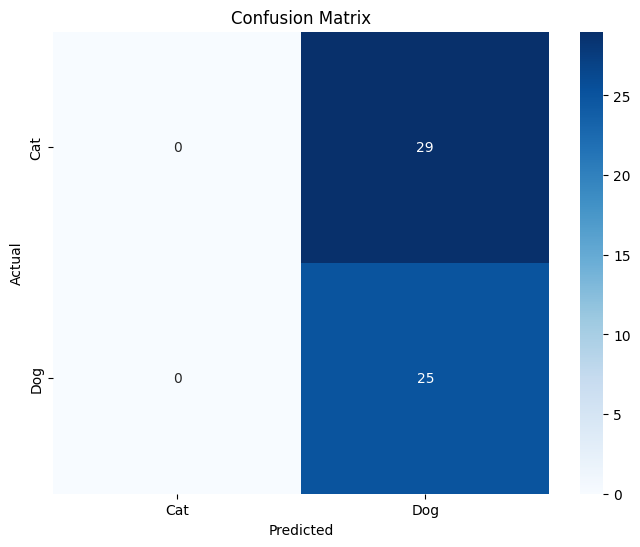

In [14]:
# Show confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

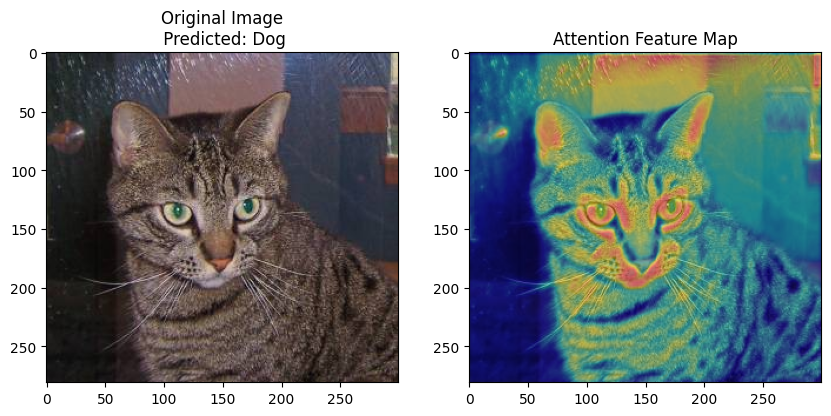

In [18]:
# Function to visualise the attention feature Maps
def visualise_attention(model, image_path, ground_truth_label, class_names):
  # set the model in evaluation
    model.eval()
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img)
    img_transformed = transform(img_pil).unsqueeze(0).to(device)
    
    with torch.no_grad():
      outputs, attention = model(img_transformed)
      _, predicted = torch.max(outputs, 1)
      predicted_label = predicted.item()

    attention = attention[0].cpu().numpy()
    attention = np.mean(attention, axis=0) 
    
    # Reshape attention weights to the spatial dimensions of the image
    attention = attention.reshape(128, 128)
    attention = cv2.resize(attention, (img.shape[1], img.shape[0]))
    attention = (attention - attention.min()) / (attention.max() - attention.min())
    attention = np.uint8(255 * attention)
    attention_colored = cv2.applyColorMap(attention, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, attention_colored, 0.4, 0)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(f"Original Image\n Predicted: {class_names[predicted_label]}")

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Attention Feature Map")

    plt.show()

  # show the images
visualise_attention(model, '/home/ubuntu/data/projects/csc6203/PetImages_lite/Cat/1.jpg', 0, dataset.classes)


# Multi Head Attention

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np


In [2]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert out_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = out_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.to_queries = nn.Linear(in_dim, out_dim, bias=False)
        self.to_keys = nn.Linear(in_dim, out_dim, bias=False)
        self.to_values = nn.Linear(in_dim, out_dim, bias=False)
        self.unify_heads = nn.Linear(out_dim, out_dim)

    def forward(self, x):
        b, t, d = x.size()
        queries = self.to_queries(x).view(b, t, self.num_heads, self.head_dim) 
        keys = self.to_keys(x).view(b, t, self.num_heads, self.head_dim)
        values = self.to_values(x).view(b, t, self.num_heads, self.head_dim)
        
        scores = torch.einsum('bthd,bThd->bhtT', queries, keys) * self.scale
        scores = F.softmax(scores, dim=-1)
        out = torch.einsum('bhtT,bThd->bthd', scores, values)
        out = out.reshape(b, t, -1) 
        out = self.unify_heads(out)
        
        return out, scores

class VisionSelfAttentionModel(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_dim=128, num_heads=8):
        super(VisionSelfAttentionModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.attention = MultiHeadSelfAttention(hidden_dim, hidden_dim, num_heads)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.attention_weights = None

    def forward(self, x):
        b, c, h, w = x.size()
        x = self.conv1(x)
        b, c, h, w = x.size()
        x = x.view(b, c, -1)
        x = x.transpose(1, 2)
        x, attention_weights = self.attention(x)
        self.attention_weights = attention_weights
        x = x.transpose(1, 2).view(b, c, h, w)
        x = self.conv2(x)
        x = self.pool(x).view(b, -1)
        x = self.fc(x)
        return x


In [4]:
# Prepare the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root="/home/ubuntu/data/projects/csc6203/PetImages_lite", transform=transform)

# split the dataset in to train, test and val 70, 20, 10
train_size = int(0.7*len(dataset))
val_size = int(0.2*len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 2

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_classes = 2
num_epochs = 5
learning_rate = 0.001

# Model, criterion and optimizer
model = VisionSelfAttentionModel(in_channels=3, num_classes=num_classes, hidden_dim=128, num_heads=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

In [7]:
train(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch [1/5], Train Loss: 0.7081, Train Accuracy: 49.73%, Val Loss: 0.6938, Val Accuracy: 41.51%
Epoch [2/5], Train Loss: 0.6943, Train Accuracy: 53.23%, Val Loss: 0.6992, Val Accuracy: 36.79%


KeyboardInterrupt: 

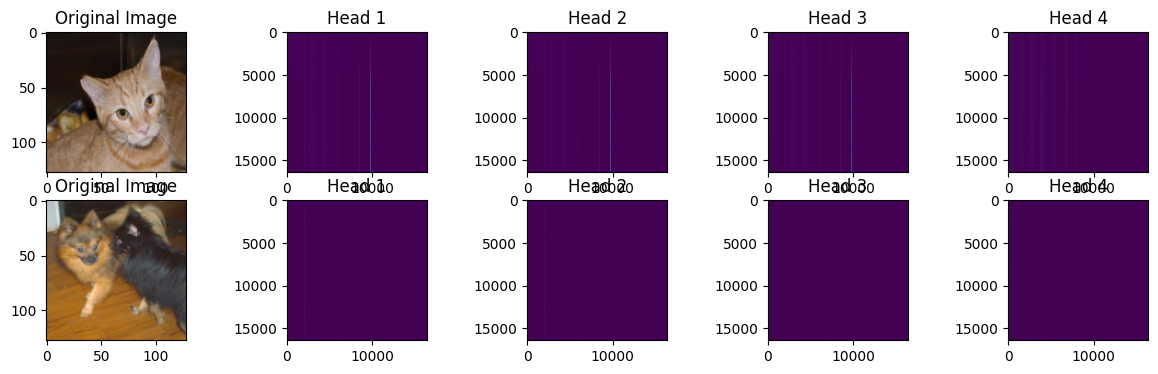

<Figure size 640x480 with 0 Axes>

In [8]:
def visualize_attention(model, dataloader, num_images=2):
    model.eval()
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)
    _ = model(images)
    attention_weights = model.attention_weights.cpu().detach().numpy()
    
    fig, axes = plt.subplots(num_images, model.attention.num_heads + 1, figsize=(15, num_images * 2))
    for i in range(num_images):
        axes[i, 0].imshow(images[i].cpu().permute(1, 2, 0))
        axes[i, 0].set_title("Original Image")
        for j in range(model.attention.num_heads):
            ax = axes[i, j + 1]
            ax.imshow(attention_weights[i, j], cmap='viridis')
            ax.set_title(f'Head {j+1}')
    plt.show()
    plt.tight_layout()
visualize_attention(model, val_loader)

# Positional Encoding

In [11]:
import torch
import torch.nn as nn
import math

In [14]:
class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, height, width):
        super(PositionalEncoding2D, self).__init__()
        self.d_model = d_model

        pe = torch.zeros(d_model, height, width)
        x_position = torch.arange(0, width, dtype=torch.float)
        y_position = torch.arange(0, height, dtype=torch.float)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        for i in range(0, d_model, 2):
            pe[i, :, :] = torch.sin(y_position.unsqueeze(1) * div_term[i//2].unsqueeze(0))
            pe[i + 1, :, :] = torch.cos(y_position.unsqueeze(1) * div_term[i//2].unsqueeze(0))

        for i in range(0, d_model, 2): 
            pe[i, :, :] += torch.sin(x_position.unsqueeze(1).transpose(0, 1) * div_term[i//2].unsqueeze(0))
            pe[i + 1, :, :] += torch.cos(x_position.unsqueeze(1).transpose(0, 1) * div_term[i//2].unsqueeze(0))

        self.register_buffer("pe", pe.unsqueeze(0))
        

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :x.size(2), :x.size(3)]
        return x

In [15]:
# Example usage:
if __name__ == "__main__":
    batch_size = 2
    channels = 8
    height = 32
    width = 32
    d_model = channels

    pos_encoder = PositionalEncoding2D(d_model=d_model, height=height, width=width)
    input_tensor = torch.randn(batch_size, channels, height, width)
    output_tensor = pos_encoder(input_tensor)

    print(output_tensor.shape)  # Should output: torch.Size([2, 8, 32, 32])

torch.Size([2, 8, 32, 32])


# DETR

In [1]:
import torch
import torchvision.transforms as T
from PIL import Image
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [12]:
# Load the pre-trained DETR model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True).to(device)
model.eval()


Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_detr_main


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [5]:
# Define the transforms for the input image
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [8]:
# Load an image from a URL
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

# Preprocess the image
img = transform(im).unsqueeze(0)
img = img.to(device)

In [9]:
# Make predictions
outputs = model(img)

# Post-process the outputs
def post_process(outputs, threshold=0.7):
    # Keep only predictions with confidence score above the threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # Convert bounding boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    
    return probas[keep], bboxes_scaled

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = out_bbox.cpu().clone()
    b = box_cxcywh_to_xyxy(b)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)
    
probas, bboxes = post_process(outputs)


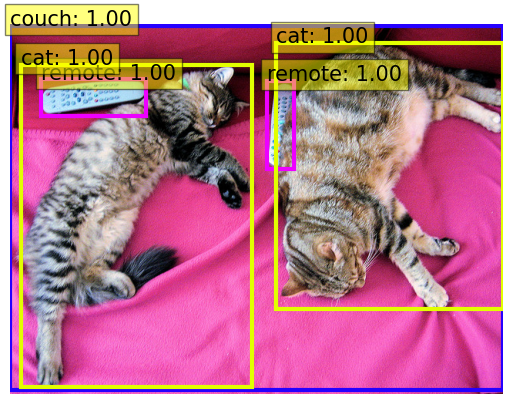

In [11]:
# Define COCO classes
COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Plot the image with bounding boxes
def plot_results(pil_img, prob, boxes):
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = plt.cm.hsv(torch.linspace(0, 1, len(COCO_CLASSES))).tolist()

    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        cl = p.argmax()
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=colors[cl], linewidth=3))
        text = f'{COCO_CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

plot_results(im, probas, bboxes)

# Audio Classification with Wav2Vec2

In [13]:
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure you're using a GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [14]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./data", download=True)

        def load_list(filename):
            with open(filename) as f:
                return [os.path.join(self._path, line.strip()) for line in f]

        if subset == "validation":
            self._walker = load_list(self._path + '/validation_list.txt')
        elif subset == "testing":
            self._walker = load_list(self._path + '/testing_list.txt')
        elif subset == "training":
            excludes = load_list(self._path + '/validation_list.txt') + load_list(self._path + '/testing_list.txt')
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

train_set = SubsetSC("training")
val_set = SubsetSC("validation")
test_set = SubsetSC("testing")


In [19]:
from torch.utils.data import DataLoader

target_sample_rate = 16000
max_length = 16000  # 1 second

def label_to_index(word):
    return labels.index(word)

def collate_fn(batch):
    tensors, targets = [], []

    for waveform, sample_rate, label, *_ in batch:
        if sample_rate != target_sample_rate:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)(waveform)
        if waveform.size(1) > max_length:
            waveform = waveform[:, :max_length]
        elif waveform.size(1) < max_length:
            waveform = torch.nn.functional.pad(waveform, (0, max_length - waveform.size(1)))

        tensors.append(waveform)
        targets.append(label_to_index[label])

    tensors = torch.stack(tensors)
    targets = torch.tensor(targets)
    return tensors, targets

batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=48)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=8)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=8)

labels = sorted(list(set(datapoint[2] for datapoint in val_set)))
label_to_index = {label: i for i, label in enumerate(labels)}
index_to_label = {i: label for label, i in label_to_index.items()}

In [16]:
class SpeechRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(SpeechRecognitionModel, self).__init__()
        # Load the Wav2Vec2 Model
        bundle = torchaudio.pipelines.WAV2VEC2_LARGE
        self.wav2vec2 = bundle.get_model().to(device)
        self.lstm = nn.LSTM(input_size=1024, hidden_size=128, num_layers = 2, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
        

    def forward(self, x):
        # Remove the channel dimension
        x = x.squeeze(1)
        # use wav2vec2 and lstm
        with torch.no_grad():
            x, _ = self.wav2vec2(x)

        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x


In [20]:
model = SpeechRecognitionModel(num_classes=len(labels)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return running_loss / len(loader), accuracy

num_epochs = 2
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, val_accuracy = validate(model, val_loader, criterion)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7feb09499580>
Traceback (most recent call last):
  File "/home/ubuntu/data/anaconda3/envs/qml-gpu/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/ubuntu/data/anaconda3/envs/qml-gpu/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/ubuntu/data/anaconda3/envs/qml-gpu/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ubuntu/data/anaconda3/envs/qml-gpu/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ubuntu/data/anaconda3/envs/qml-gpu/lib/python3.11/multiprocessing/connection.py", line 948, in wait
    ready = selector.se

ValueError: The number of FixedLocator locations (35), usually from a call to set_ticks, does not match the number of labels (5).

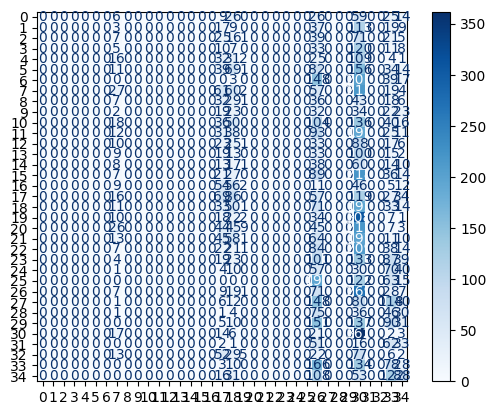

In [22]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()
